# Parte 2 de la Segunda Práctica de Aprendizaje Estadístico

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model #type: ignore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import os, random
import time
from tensorflow.keras import regularizers  #type: ignore

2026-01-02 22:01:25.034286: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 22:01:25.035809: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-02 22:01:25.060440: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-02 22:01:25.060466: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-02 22:01:25.061173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Para que sea determinista

In [ ]:
SEED = 42

# 1) Semillas de Python/NumPy
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 2) Semilla de TensorFlow
keras.utils.set_random_seed(SEED)
# equivalente a: tf.random.set_seed(SEED) pero también cubre partes de Keras

# 3) Intentar forzar operaciones deterministas (GPU/CPU)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

# limitar paralelismo para reducir variación en CPU
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)

In [3]:
df = pd.read_csv('diabetesBRFSS2015.csv')

In [4]:
df

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


Dividir datos en train validation test, ya luego hacer lo de estandarizar

In [5]:
X = df.drop("Diabetes_binary", axis=1) 
y = df["Diabetes_binary"]

Para dividir un DataFrame de pandas en conjuntos de entrenamiento (train), validación (validation) y prueba (test) usando scikit-learn (sklearn), puedes usar la función train_test_split dos veces

In [6]:
# Paso 1: dividir en train+val y test (80% / 20%)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
# Paso 2: dividir train+val en train y validation (75% de 80% = 60% total, y 25% de 80% = 20% total)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=SEED, stratify=y_trainval
)

In [7]:
for c in df.columns:
    print(f"{c}: {df[c].unique()}")

Diabetes_binary: [0. 1.]
HighBP: [1. 0.]
HighChol: [0. 1.]
CholCheck: [1. 0.]
BMI: [26. 28. 29. 18. 31. 32. 27. 24. 21. 58. 30. 20. 22. 38. 40. 25. 36. 47.
 19. 37. 41. 23. 34. 35. 42. 17. 33. 44. 15. 52. 69. 56. 45. 39. 92. 53.
 98. 50. 46. 79. 48. 16. 63. 72. 54. 49. 68. 43. 84. 73. 76. 55. 51. 75.
 57. 60. 12. 77. 82. 67. 71. 61. 14. 81. 59. 86. 13. 87. 65. 95. 89. 62.
 64. 66. 85. 70. 83. 80. 78. 74.]
Smoker: [0. 1.]
Stroke: [0. 1.]
HeartDiseaseorAttack: [0. 1.]
PhysActivity: [1. 0.]
Fruits: [0. 1.]
Veggies: [1. 0.]
HvyAlcoholConsump: [0. 1.]
AnyHealthcare: [1. 0.]
NoDocbcCost: [0. 1.]
GenHlth: [3. 1. 2. 4. 5.]
MentHlth: [ 5.  0.  7.  3.  4.  2. 30. 20.  1. 15. 10. 25. 14. 28.  6. 29. 26. 12.
 16. 22. 13.  8.  9. 21. 18. 17. 27. 24. 23. 11. 19.]
PhysHlth: [30.  0. 10.  3.  6.  4. 15.  1.  2. 14.  7. 25. 21. 20.  5.  8. 22. 23.
 29. 12. 18. 28. 26. 24. 27. 11. 13. 16. 17.  9. 19.]
DiffWalk: [0. 1.]
Sex: [1. 0.]
Age: [ 4. 12. 13. 11.  8.  1.  6.  3.  7. 10.  9.  5.  2.]
Education: [6

El problema es decidir como escalar las variables categoricas ordinales, los métodos disponibles son:
- Usarla tal cual con label encoding
- normalizar/estandarizar con min-max o zscore como si fuera una variable continua
- One-Hot encoding
- Embeddings

Nuestras variables no son lo suficientemente complejas para aplicar embeddings, y label encoding a secas no vamos a usar porque no estamos escalando. Entre normalizar/estandarizar y one-hot encoding cual escoger. 

Elige numérico + normalización si:

- El orden de las categorías importa respecto a la variable objetivo.
- Se espera un efecto monótono (“más educación” tiende a subir/bajar el target).

Riesgo: si el efecto real es irregular, fuerzas una forma incorrecta.

Elige one-hot si…

- Podría haber saltos raros (p.ej. “secundaria” cambia mucho, “universidad” no tanto).

Riesgo: pierdes el orden y puedes sobreajustar más fácil.

Vamos a visualizar la relación entre la variable objetivo y las variables categóricas ordinales, para decidir si escalamos con standard scaler o one hot encoding. Para visualizar la relación entre dos variables categóricas vamos a utilizar gráficos de barras de proporción, mostrando para cada valor de X el porcentaje de instancias que son Y = 1 (que tienen diabetes)

In [ ]:
def plot_binary_vs_ordinal(X, Y, sort_levels=True, level_order=None,
                          titles=None, show_counts=True):
    """
    Hace un gráfico con matplotlib para una Y binaria vs X categórica ordinal: barras del % de Y=1 por nivel de X
    """
    Xs = pd.Series(X, name="X")
    Ys = pd.Series(Y, name="Y")

    Ys = Ys.astype(int)

    # Agrega conteos por nivel
    counts = (
        pd.DataFrame({"X": Xs, "Y": Ys})
        .groupby("X")["Y"]
        .agg(n="size", pos="sum")
    )
    counts["neg"] = counts["n"] - counts["pos"]

    # Orden de niveles
    if level_order is not None:
        levels = list(level_order)
        # reindex para incluir niveles aunque no aparezcan (n=0)
        counts = counts.reindex(levels, fill_value=0)
    else:
        levels = list(counts.index)

        if sort_levels:
            # intenta ordenar numéricamente si se puede, si no, orden lexicográfico
            def try_float(v):
                try:
                    return float(v)
                except Exception:
                    return None

            numeric_vals = [try_float(v) for v in levels]
            if all(v is not None for v in numeric_vals):
                # ordenar por valor numérico, manteniendo etiqueta original
                levels = [x for _, x in sorted(zip(numeric_vals, levels), key=lambda t: t[0])]
            else:
                levels = sorted(levels, key=lambda v: str(v))

            counts = counts.reindex(levels)

    # Proporciones
    n = counts["n"].to_numpy()
    pos = counts["pos"].to_numpy()

    p_pos = np.divide(pos, n, out=np.zeros_like(pos, dtype=float), where=n > 0)

    x_idx = np.arange(len(levels))
    xticklabels = [str(l) for l in levels]

    t1 = (titles or {}).get("p1", "Porcentaje de Y=1 por nivel de X")

    fig1, ax1 = plt.subplots()
    ax1.bar(x_idx, p_pos * 100)
    ax1.set_title(t1)
    ax1.set_xlabel("X")
    ax1.set_ylabel("% de Y=1")
    ax1.set_xticks(x_idx)
    ax1.set_xticklabels(xticklabels, rotation=0)
    ax1.set_ylim(0, 100)

    # etiquetas %
    for xi, val, ni in zip(x_idx, p_pos * 100, n):
        ax1.text(xi, val + 1, f"{val:.1f}%", ha="center", va="bottom")
        if show_counts:
            ax1.text(xi, 1, f"n={int(ni)}", ha="center", va="bottom")

    plt.show()


    return fig1, ax1

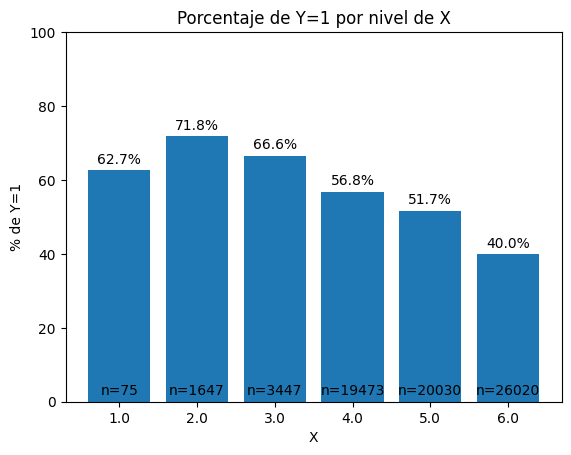

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Porcentaje de Y=1 por nivel de X'}, xlabel='X', ylabel='% de Y=1'>)

In [9]:
plot_binary_vs_ordinal(df['Education'], df['Diabetes_binary'])

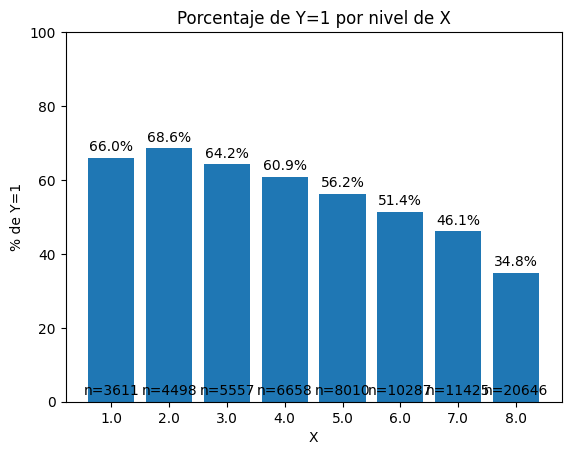

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Porcentaje de Y=1 por nivel de X'}, xlabel='X', ylabel='% de Y=1'>)

In [10]:
plot_binary_vs_ordinal(df['Income'], df['Diabetes_binary'])

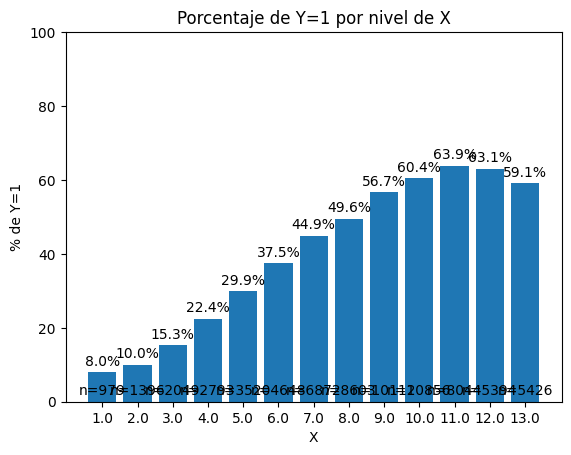

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Porcentaje de Y=1 por nivel de X'}, xlabel='X', ylabel='% de Y=1'>)

In [11]:
plot_binary_vs_ordinal(df['Age'], df['Diabetes_binary'])

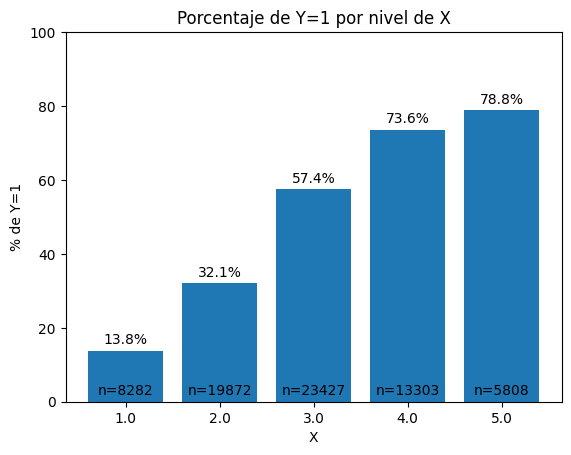

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Porcentaje de Y=1 por nivel de X'}, xlabel='X', ylabel='% de Y=1'>)

In [12]:
plot_binary_vs_ordinal(df['GenHlth'], df['Diabetes_binary'])

Viendo los gráficos esta claro que el orden importa muchísimo, vamos a usar estandarización normal con zscore para las categóricas ordinales.

Para las variables continuas obviamente lo mismo

In [13]:
standarize = ["Age", "GenHlth", "Income", "Education", "MentHlth", "BMI", "PhysHlth"]

In [14]:
scaler = StandardScaler()

# La primera vez hacemos fit_transform para que aprenda los parámetros (media y desviación estándar) con los datos de train
# Cuando vayamos a escalar validación o test solo transform()
X_train[standarize] = scaler.fit_transform(X_train[standarize])

# Escalar val/test con el MISMO scaler (ya fiteado en train)
X_val[standarize]  = scaler.transform(X_val[standarize])
X_test[standarize] = scaler.transform(X_test[standarize])

Funciones para poder visualizar las métricas del entrenamiento

In [ ]:

# FUNCIONES AUXILIARES PARA ANÁLISIS DE ENTRENAMIENTO ----------
# Estas funciones solo se usan dentro de la función principal study_training()

def summarize_training(history, metric="auc"):
    """
    Resume el entrenamiento a partir del objeto History de Keras.
    Devuelve:
      - best_epoch (1-indexed)
      - best_val_metric
      - last_epoch
      - stopped_early (True si no llegó al max epochs)
      - gaps (train vs val en el best_epoch)
      - flags NaN/Inf
    """
    h = history.history
    last_epoch = len(h["loss"])
    max_epochs_requested = history.params.get("epochs", None)
    stopped_early = (max_epochs_requested is not None) and (last_epoch < max_epochs_requested)

    # seguridad: métricas
    train_key = metric
    val_key = f"val_{metric}"
    if train_key not in h or val_key not in h:
        raise ValueError(f"No encuentro {train_key} / {val_key} en history. Keys: {list(h.keys())}")

    # mejor epoch según val_metric (max para auc/acc; min para loss)
    mode = "max"
    if metric == "loss":
        mode = "min"

    val_values = np.array(h[val_key], dtype=np.float64)
    if mode == "max":
        best_idx = int(np.nanargmax(val_values))
    else:
        best_idx = int(np.nanargmin(val_values))

    best_epoch = best_idx + 1
    best_val = float(val_values[best_idx])

    # gaps en best epoch
    train_at_best = float(np.array(h[train_key], dtype=np.float64)[best_idx])
    gap = train_at_best - best_val  # (para acc/auc) positivo = train mejor que val

    # NaN / Inf detection en todas las series numéricas
    nan_or_inf = {}
    for k, v in h.items():
        arr = np.array(v, dtype=np.float64)
        nan_or_inf[k] = (np.isnan(arr).any() or np.isinf(arr).any())

    return {
        "best_epoch": best_epoch,
        "best_val": best_val,
        "last_epoch": last_epoch,
        "max_epochs_requested": max_epochs_requested,
        "stopped_early": stopped_early,
        "gap_train_minus_val": gap,
        "nan_or_inf_flags": nan_or_inf,
    }


def plot_learning_curves(history):
    """
    Muestra las curvas de aprendizaje (loss, acc, auc si existen) a partir del resumen History de Keras.
    """
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, h["loss"], label="train_loss")
    plt.plot(epochs, h["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning curve: Loss")
    plt.legend()
    plt.show()

    # Accuracy si existe
    if "acc" in h and "val_acc" in h:
        plt.figure()
        plt.plot(epochs, h["acc"], label="train_acc")
        plt.plot(epochs, h["val_acc"], label="val_acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("Learning curve: Accuracy")
        plt.legend()
        plt.show()

    # AUC si existe
    if "auc" in h and "val_auc" in h:
        plt.figure()
        plt.plot(epochs, h["auc"], label="train_auc")
        plt.plot(epochs, h["val_auc"], label="val_auc")
        plt.xlabel("Epoch")
        plt.ylabel("AUC")
        plt.title("Learning curve: AUC")
        plt.legend()
        plt.show()


def plot_confusion(y_true, y_proba, threshold=0.5, title="Confusion matrix"):
    """
    Muestra la matriz de confusión y el reporte de clasificación para las predicciones binarias
    obtenidas a partir de las probabilidades predichas y un umbral de decisión dado
    """
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    plt.figure()
    disp.plot(values_format="d")
    plt.title(f"{title} (thr={threshold})")
    plt.show()

    print(classification_report(y_true, y_pred, digits=4))


def get_proba(model, X):
    # Keras devuelve (n,1) o (n,) según versión/capa; lo dejamos como (n,)
    return model.predict(X, verbose=0).reshape(-1)


def get_best_metric(history):
    """
    Devuelve las mejores métricas de entrenamiento y validación, por defecto va a por accuracy al ser la que nos piden que estudiemos para
    estudiar el underfitting
    Devuelve:
      - train_best
      - val_best
      - gap_best
      - metric_name
    """
    h = history.history

    # toma mejores valores de val_acc si existe, si no usa val_auc
    if "val_acc" in h:
        val_best = np.max(h["val_acc"])
        train_best = np.max(h["acc"])
        metric_name = "acc"
    else:
        val_best = np.max(h["val_auc"])
        train_best = np.max(h["auc"])
        metric_name = "auc"

    gap_best = float(train_best - val_best)

    return (train_best, val_best, gap_best, metric_name)

# -----------------------------

# FUNCIÓN PRINCIPAL DE ESTUDIO DE ENTRENAMIENTO ----------

def study_training(history, model, X_val, X_test, y_val_nn, y_test_nn):
    """
    Realiza un estudio completo del entrenamiento a partir del objeto History de Keras y el modelo entrenado.
    Muestra:
      - Resumen del entrenamiento
      - Curvas de aprendizaje
      - Matrices de confusión en val y test 
    """
    summary = summarize_training(history, metric="acc")
    print("=== RESUMEN ENTRENAMIENTO ===")
    print(f"Época final: {summary['last_epoch']}"
        + (f" / {summary['max_epochs_requested']}" if summary['max_epochs_requested'] is not None else ""))
    print(f"¿Paró antes de max epochs?: {summary['stopped_early']}")
    print(f"Mejor época (por val_acc): {summary['best_epoch']}  |  mejor val_acc: {summary['best_val']:.4f}")
    print(f"Gap (train_acc - val_acc) en mejor época: {summary['gap_train_minus_val']:.4f}")

    # Estabilidad (NaN/Inf)
    bad = [k for k, flag in summary["nan_or_inf_flags"].items() if flag]
    print("¿NaN/Inf detectado?:", "SÍ -> " + str(bad) if bad else "NO")

    # Curvas de aprendizaje
    plot_learning_curves(history)

    # Matrices de confusión (val y test)
    val_proba = get_proba(model, X_val)
    test_proba = get_proba(model, X_test)

    plot_confusion(y_val_nn, val_proba, threshold=0.5, title="Validation")
    plot_confusion(y_test_nn, test_proba, threshold=0.5, title="Test")

    stats = get_best_metric(history)
    train_best, val_best, gap_best, metric_name = stats

    print("\n=== DIAGNÓSTICO ===")
    print(f"Best train_{metric_name}: {train_best:.4f}")
    print(f"Best val_{metric_name}:   {val_best:.4f}")
    print(f"Gap best:                 {gap_best:.4f}")


Función que pasandole el modelo y demás hiperparámetros entrena el modelo

In [16]:
def train_and_test(model, lr=1e-3, epochs=200, batch_size=64, patience=10, verbose=0):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="acc"),
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )

    # 4) Callbacks: early stopping + guardar mejores pesos
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=patience,
            restore_best_weights=True
        )
    ]

    time_start_training = time.time()

    # 5) Entrenamiento
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=verbose,
        shuffle=False # Para que sea reproducible
    )

    time_finish_training = time.time()

    # 6) Evaluación en test
    test_metrics = model.evaluate(X_test, y_test, verbose=0)

    return history, test_metrics, (time_finish_training - time_start_training)

Función propia para dado un modelo hacer una especie de grid search sobre un grid de hiperparámetros, los hiperparámetros que vamos a dejar estudiar son:

- learning rate

Como de rápido aprende nuestra red. Un lr alto aprende rápido pero puede no converger al no encontrar el mínimo. Un lr bajo aprende mejor en general, pero puede tardar mucho o quedarse corto si se para con early stopping. Para arquitecturas más simples podemos tolerar valores más altos, para redes más profundas suele requerir valores más pequeños.

- batch_size

Número de muestras usadas para calcular cada actualización del gradiente. Un batch pequeño equivale a más ruido (a veces generaliza mejor) pero más lento. Batch grande es más estable y rápido, pero puede generalizar peor y requerir ajustar lr. Se suelen usar los valores 32, 64, 128, 256. Si tuvieramos muchos datos podríamos pensar en probar batch mayores, o si tuvieramos pocos datos batch más pequeños. Para nuestro, los valores especificados son correctos.

- epochs

Número máximo de pasadas completas por el conjunto de entrenamiento. En nuestro caso entrenamos siempre con early stopping, por lo tanto no nos tenemos que preocupar en exceso si ponemos epochs de más. Una red más compleja requerirá más epochs.

Para comparar modelos (y para monitorizar el early_stopping en la función anterior `train_and_test`) vamos a usar AUC en lugar de accuracy, ya que no depende de un umbral de decisión concreto y evalúa el rendimiento del modelo a lo largo de todos los umbrales posibles. Además, en problemas como el nuestro, de predicción de diabetes, lo importante es ordenar correctamente las instancias: que los casos positivos reciban probabilidades más altas que los negativos. AUC mide precisamente eso: la probabilidad de que una instancia positiva tomada al azar tenga un score mayor que una negativa

In [ ]:
import itertools

def grid_search_nn(model, grid, patience=10, verbose=0, score_metric="auc"):
    """
    grid: dict con keys: "lr", "batch_size", "epochs"
          Ej: {"lr":[1e-3, 5e-4], "batch_size":[32,64], "epochs":[50,150]}
    score_metric: métrica de test para elegir el mejor, por defecto "auc".
    """
    # 1) Crear un "modelo base" limpio y obtener pesos iniciales
    base_model = keras.models.clone_model(model)
    # asegurar que tiene pesos iniciales
    if not base_model.built:
        base_model.build((None, X_train.shape[1]))
    initial_weights = base_model.get_weights()

    # Validación de grid
    for k in ["lr", "batch_size", "epochs"]:
        if k not in grid or not isinstance(grid[k], (list, tuple)) or len(grid[k]) == 0:
            raise ValueError(f"grid debe tener una lista no vacía en la clave '{k}'")

    results = []
    best = None

    combos = list(itertools.product(grid["lr"], grid["batch_size"], grid["epochs"]))

    for lr, batch_size, epochs in combos:
        tf.keras.utils.set_random_seed(SEED)

        # 2) Clonar modelo y resetear pesos a los iniciales
        trial_model = keras.models.clone_model(model)
        if not trial_model.built:
            trial_model.build((None, X_train.shape[1]))
        trial_model.set_weights(initial_weights)

        # 3) Entrenar + test
        history, test_metrics, train_time = train_and_test(
            trial_model,
            lr=lr,
            epochs=epochs,
            batch_size=batch_size,
            patience=patience,
            verbose=verbose
        )

        # 4) Pasar métricas de test a dict
        metrics_dict = dict(zip(trial_model.metrics_names, test_metrics))

        # score para comparar
        if score_metric not in metrics_dict:
            raise ValueError(
                f"score_metric='{score_metric}' no está en metrics_names={trial_model.metrics_names}"
            )
        score = float(metrics_dict[score_metric])

        row = {
            "lr": lr,
            "batch_size": batch_size,
            "epochs": epochs,
            "score_metric": score_metric,
            "score": score,
            "train_time_sec": float(train_time),
            "test_metrics": metrics_dict,
            "history": history, 
        }
        results.append(row)

        if (best is None) or (score > best["score"]):
            best = row

    return best, results
    

## Arquitectura simple, sin ninguna técnica de regularización

In [18]:
X_train.shape

(42414, 21)

In [19]:
# Modelo baseline 
model = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # binaria
])



Como tenemos early stopping con ``restore_best_weights`` a True, no nos preocupa tener epochs de más mientras el tiempo de entrenamiento se mantenga razonable. Ponemos 50 que es más que suficiente para una red tan simple

In [20]:
best_simple, all_simples = grid_search_nn(model, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,64], "epochs":[50]}, patience=10)

In [21]:
# Mejores hiperparámetros para el modelo simple

best_simple

{'lr': 0.0001,
 'batch_size': 64,
 'epochs': 50,
 'score_metric': 'auc',
 'score': 0.8298231959342957,
 'train_time_sec': 40.226590156555176,
 'test_metrics': {'loss': 0.5022129416465759,
  'acc': 0.7493457794189453,
  'auc': 0.8298231959342957,
  'precision': 0.7203951478004456,
  'recall': 0.8149667382240295},
 'history': <keras.src.callbacks.History at 0x7e0164092110>}

In [22]:
history, test_metrics, train_time = train_and_test(model, 0.0001, 50, 64, patience=10,verbose=1) # Activamos verbose para estudiar el entrenamiento

Epoch 1/50
663/663 [==============================] - 1s 2ms/step - loss: 0.5815 - acc: 0.6986 - auc: 0.7689 - precision: 0.6860 - recall: 0.7327 - val_loss: 0.5237 - val_acc: 0.7429 - val_auc: 0.8153 - val_precision: 0.7153 - val_recall: 0.8071
Epoch 2/50
663/663 [==============================] - 1s 2ms/step - loss: 0.5156 - acc: 0.7457 - auc: 0.8202 - precision: 0.7239 - recall: 0.7945 - val_loss: 0.5106 - val_acc: 0.7495 - val_auc: 0.8240 - val_precision: 0.7196 - val_recall: 0.8175
Epoch 3/50
663/663 [==============================] - 1s 2ms/step - loss: 0.5094 - acc: 0.7496 - auc: 0.8248 - precision: 0.7264 - recall: 0.8006 - val_loss: 0.5082 - val_acc: 0.7498 - val_auc: 0.8258 - val_precision: 0.7197 - val_recall: 0.8184
Epoch 4/50
663/663 [==============================] - 1s 1ms/step - loss: 0.5071 - acc: 0.7503 - auc: 0.8266 - precision: 0.7268 - recall: 0.8023 - val_loss: 0.5070 - val_acc: 0.7503 - val_auc: 0.8268 - val_precision: 0.7201 - val_recall: 0.8188
Epoch 5/50
663/6

Entendiendo la salida del entrenamiento:

- loss: valor de la función de perdida (en nuestro caso binary_crossentropy), valores entre 0 y 1, a menor pérdida mejor el modelo, igualmente esta métrica es simplemente para guiar el entrenamiento, no para interpretar resultados.
- Binary accuracy (acc): proporción de predicciones correctas respecto al total (nº instancias predichas correctamente / nº total instancias). Es útil sobre todo si las clases están balanceadas, como es nuestro caso.
- Area under the curve (auc): métrica para evaluar clasificadores binarios, representando la capacidad del modelo para distinguir entre clases positivas y negativas, un valor más alto (cercano a 1) indica mejor rendimiento, mientras que 0.5 es azar y 0 es un clasificador perfecto inverso. Si estás clasificando, por ejemplo, si un cliente comprará (1) o no comprará (0):
Un AUC = 0.85 significa que, si coges al azar un par (comprador, no-comprador), en el 85 % de los pares la predicción del modelo para el comprador será mayor (más cerca de 1) que el no-comprador.
- Precision: de todas las predicciones positivas, cuantas eran realmente positivas (nº predichos positivos acertados (TP) / TP + nº predichos positivos fallados (FP)), sirve para estudiar los falsos positivos
- Recall/sensibilidad: de todas las instancias realmente positivas, cuantas predijimos bien (TP / TP + nº de predichos negativos fallados (FN)), sirve para estudiar los falsos negativos

Recall = "Recuperación" → ¿Recuperé todos los positivos reales?\
Precisión = "Exactitud" → ¿Fueron exactos mis positivos?

=== RESUMEN ENTRENAMIENTO ===
Época final: 50 / 50
¿Paró antes de max epochs?: False
Mejor época (por val_acc): 30  |  mejor val_acc: 0.7533
Gap (train_acc - val_acc) en mejor época: 0.0031
¿NaN/Inf detectado?: NO


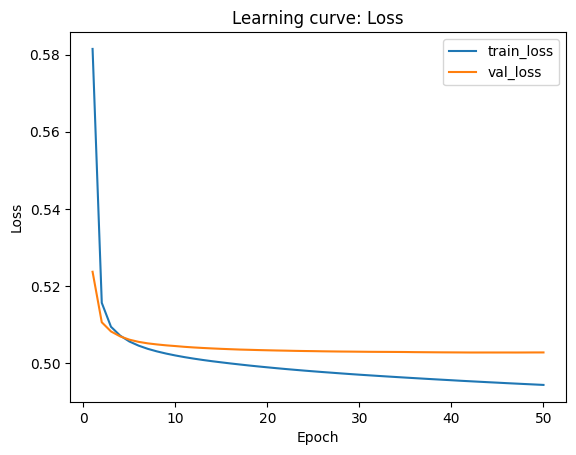

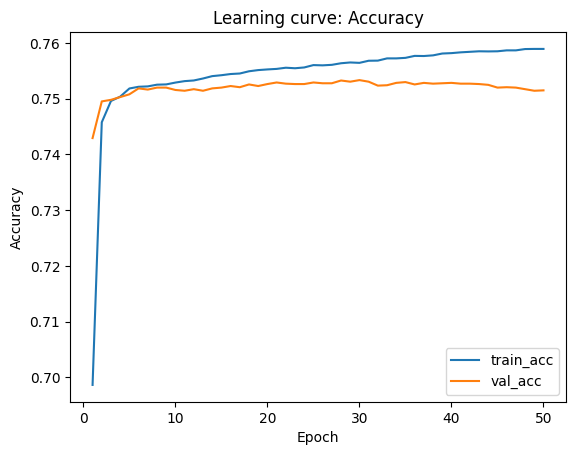

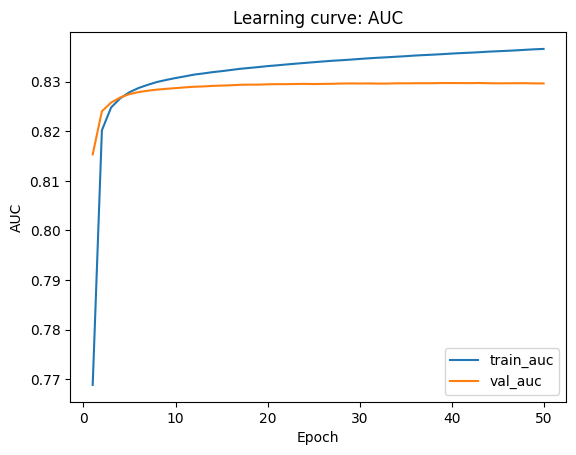

<Figure size 640x480 with 0 Axes>

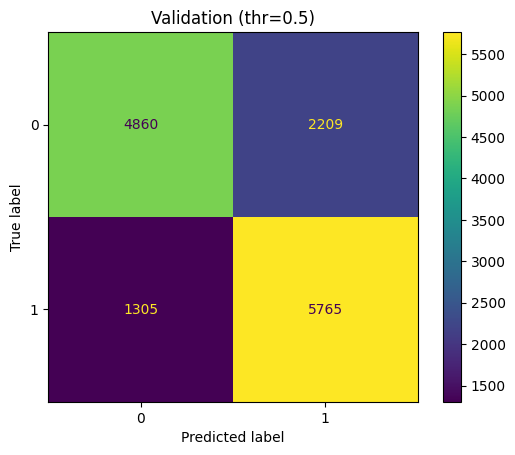

              precision    recall  f1-score   support

         0.0     0.7883    0.6875    0.7345      7069
         1.0     0.7230    0.8154    0.7664      7070

    accuracy                         0.7515     14139
   macro avg     0.7556    0.7515    0.7504     14139
weighted avg     0.7556    0.7515    0.7504     14139



<Figure size 640x480 with 0 Axes>

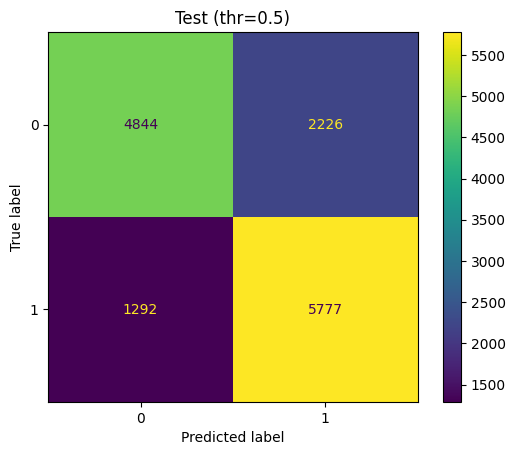

              precision    recall  f1-score   support

         0.0     0.7894    0.6851    0.7336      7070
         1.0     0.7219    0.8172    0.7666      7069

    accuracy                         0.7512     14139
   macro avg     0.7556    0.7512    0.7501     14139
weighted avg     0.7556    0.7512    0.7501     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7589
Best val_acc:   0.7533
Gap best:                 0.0056


In [23]:
study_training(history, model, X_val, X_test, y_val, y_test)

In [24]:
print(f"Evaluación en test: {dict(zip(model.metrics_names, test_metrics))}")

Evaluación en test: {'loss': 0.5010417699813843, 'acc': 0.7511846423149109, 'auc': 0.8305436372756958, 'precision': 0.7218543291091919, 'recall': 0.8172301650047302}


Conclusiones del entrenamiento red básica:

Tenemos un buen modelo como baseline, el entrenamiento es estable y consistente, la pérdida desciende y se mantiene en valores similares entre entrenamiento y validación (loss final ≈ 0.494 vs val_loss ≈ 0.503), sin señales de NaN/Inf. Las métricas también evolucionan de forma suave, lo que sugiere que la optimización está funcionando correctamente y que no hay problemas numéricos ni de inestabilidad, por lo que descartamos problemas de vanishing o exploding gradient, aunque en una red tan simple dificilmente ibamos a tener esos problemas.

En términos de convergencia, el modelo aprendió bastante rápido, si nos fijamos en las gráficas se aprecia como rápidamente aprendio en los primeros 10 epochs y a partir de ahí la mejora es muy paulatina (por ejemplo, val_auc ≈ 0.8296–0.8297 y val_loss prácticamente constante). Este comportamiento es coherente con la arquitectura, al ser tan simple aprende rápido.

Respecto a generalización, no se aprecia sobreajuste: el accuracy de entrenamiento y validación es muy parecido. En la mejor época por val_acc (época 28, val_acc ≈ 0.7532), el gap entre entrenamiento y validación es bajo (del orden de unas milésimas), y el rendimiento en test se mantiene alineado con validación (test acc ≈ 0.7511). Esto sugiere que el modelo generaliza bien al no degradarse al pasar a datos no vistos.

En cuanto a precision y recall, el modelo presenta un perfil orientado a sensibilidad: en test obtiene recall ≈ 0.8169, lo que significa que recupera la mayoría de casos positivos y deja relativamente pocos falsos negativos. La precision ≈ 0.7219 es algo más baja, indicando que una fracción de las predicciones positivas son falsos positivos. En conjunto, con el umbral de decisión estándar 0.5, el modelo favorece detectar positivos (recall alto) a costa de cierta pérdida en precisión. En nuestro caso de detectar una enfermedad a futuro, es bueno tener más recall. Preferimos asegurar que detectamos todo a que se nos escapen posibles enfermos.

## Arquitectura compleja, con varias técnicas de regularización

Los métodos de regularización son un conjunto de técnicas que buscan mejorar la generalización y reducir el sobreajuste. No deben confundirse con técnicas orientadas a estabilizar el entrenamiento y mitigar vanishing/exploding gradients (p. ej., inicialización adecuada, gradient clipping, etc.), aunque algunas técnicas como Batch Normalization pueden tener efectos en ambos aspectos.

Vamos a repasar cuales eran los métodos de regularización que tenemos disponibles:

- Penalizaciones de la función de pérdida (regularización L1/L2)

Ambas añaden un término de penalización a la función de pérdida para desincentivar pesos grandes, favoreciendo soluciones con pesos pequeños y mejor generalización. L1 (Lasso) penaliza la suma de valores absolutos y algunos pesos pueden quedar exactamente en 0. L2 (Ridge / weight decay) penaliza la suma de cuadrados y no suele llevar pesos a 0 exactamente, pero los mantiene pequeños.

- Regularización estructural (Dropout, BatchNormalization)

Dropout consiste en “apagar” (poner a cero) de forma aleatoria un porcentaje de activaciones/neuronas durante el entrenamiento. Esto evita que la red dependa demasiado de neuronas concretas, reduce la co-adaptación y suele mejorar la generalización. En inferencia no se apagan neuronas; se usa la red completa (con el escalado correspondiente).

Batch Normalization (BatchNorm) normaliza las activaciones de una capa usando la media y varianza del mini-batch, para que queden aproximadamente con media 0 y varianza 1, y después aplica dos parámetros aprendibles que permiten reescalar y desplazar esas activaciones. Suele estabilizar y acelerar el entrenamiento (y a veces tiene un efecto regularizador ligero). En inferencia usa estadísticas acumuladas (running mean/var) en lugar de las del mini-batch.

No es obligatorio usar Dropout y BatchNorm juntos; en muchos casos BatchNorm ya estabiliza bastante y añadir Dropout puede no ayudar o incluso empeorar, según el modelo y el dataset.

- Regularización procedimental (early stopping, data augmentation, añadir ruido)

Early stopping ya lo usamos en la red simple, si la red no mejora en un número determinado de epochs u otro criterio que definamos, deja de entrenar y devuelve el mejor modelo entre todos los epochs.

Early stopping ya lo usamos en la red simple: durante el entrenamiento se monitoriza una métrica (por ejemplo val_auc o val_loss) y, si no mejora tras un número definido de epochs (patience), se detiene el entrenamiento. Además, con restore_best_weights=True se recuperan los pesos del mejor epoch, no los del último, reduciendo el riesgo de sobreajuste por entrenar “de más”.

Data augmentation consiste en generar ejemplos nuevos a partir de los datos disponibles aplicando transformaciones que no cambian la etiqueta (muy común en visión: rotaciones, recortes, flips; en audio: time shift, ruido; en texto: técnicas específicas). Esto aumenta la variedad efectiva del dataset y ayuda a generalizar mejor.

Añadir ruido introduce perturbaciones controladas para hacer el modelo más robusto: puede añadirse a las entradas (p. ej. ruido gaussiano), a las activaciones o incluso a los pesos/gradientes (según el enfoque). La idea es forzar a la red a aprender patrones estables y no depender de detalles demasiado específicos del conjunto de entrenamiento.

Primero vamos a hacer la arquitectura compleja sin ningún método de regularización, a ver que pasa. Como solamente es un experimento no vamos a hacer grid search

In [25]:
# Modelo complejo sin regularización
model_complex_no_reg = Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(512, activation="relu"),
    layers.Dense(256, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

In [26]:
best_complex_no_reg, all_simples = grid_search_nn(model_complex_no_reg, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,512], "epochs":[200]}, patience=20)

In [27]:
best_complex_no_reg

{'lr': 0.0001,
 'batch_size': 512,
 'epochs': 200,
 'score_metric': 'auc',
 'score': 0.8294239044189453,
 'train_time_sec': 25.329573392868042,
 'test_metrics': {'loss': 0.5043412446975708,
  'acc': 0.7522455453872681,
  'auc': 0.8294239044189453,
  'precision': 0.7145607471466064,
  'recall': 0.84000563621521},
 'history': <keras.src.callbacks.History at 0x7e01742004c0>}

In [28]:
history_complex_no_reg, _, _ = train_and_test(model_complex_no_reg, lr=0.0001, epochs=200, batch_size=64, verbose=1)

Epoch 1/200
663/663 [==============================] - 3s 4ms/step - loss: 0.5208 - acc: 0.7441 - auc: 0.8158 - precision: 0.7269 - recall: 0.7820 - val_loss: 0.5052 - val_acc: 0.7498 - val_auc: 0.8283 - val_precision: 0.7179 - val_recall: 0.8232
Epoch 2/200
663/663 [==============================] - 2s 3ms/step - loss: 0.5036 - acc: 0.7524 - auc: 0.8293 - precision: 0.7285 - recall: 0.8047 - val_loss: 0.5039 - val_acc: 0.7501 - val_auc: 0.8292 - val_precision: 0.7163 - val_recall: 0.8280
Epoch 3/200
663/663 [==============================] - 3s 4ms/step - loss: 0.5009 - acc: 0.7538 - auc: 0.8314 - precision: 0.7298 - recall: 0.8060 - val_loss: 0.5034 - val_acc: 0.7507 - val_auc: 0.8295 - val_precision: 0.7162 - val_recall: 0.8304
Epoch 4/200
663/663 [==============================] - 2s 3ms/step - loss: 0.4989 - acc: 0.7548 - auc: 0.8328 - precision: 0.7314 - recall: 0.8053 - val_loss: 0.5031 - val_acc: 0.7515 - val_auc: 0.8298 - val_precision: 0.7169 - val_recall: 0.8311
Epoch 5/200


=== RESUMEN ENTRENAMIENTO ===
Época final: 17 / 200
¿Paró antes de max epochs?: True
Mejor época (por val_acc): 6  |  mejor val_acc: 0.7519
Gap (train_acc - val_acc) en mejor época: 0.0060
¿NaN/Inf detectado?: NO


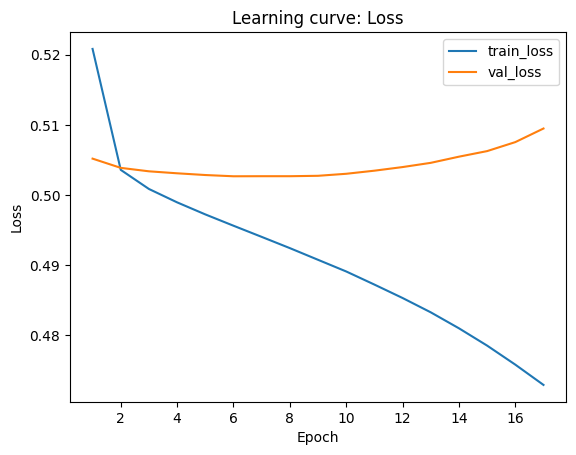

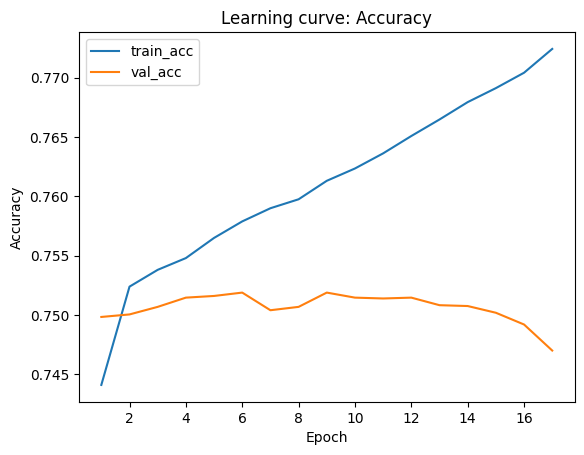

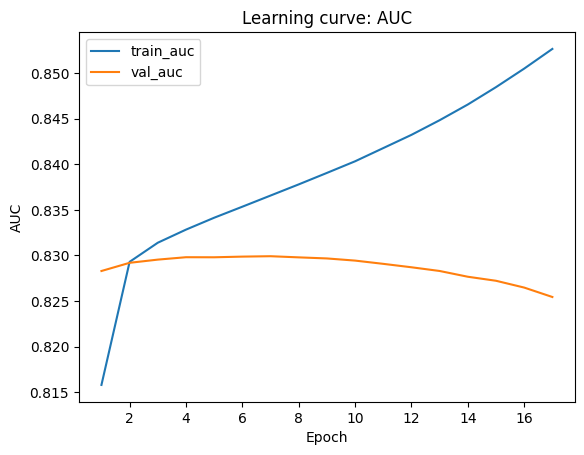

<Figure size 640x480 with 0 Axes>

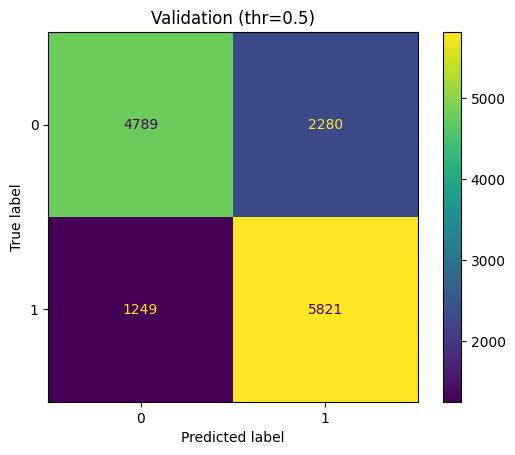

              precision    recall  f1-score   support

         0.0     0.7931    0.6775    0.7308      7069
         1.0     0.7186    0.8233    0.7674      7070

    accuracy                         0.7504     14139
   macro avg     0.7558    0.7504    0.7491     14139
weighted avg     0.7558    0.7504    0.7491     14139



<Figure size 640x480 with 0 Axes>

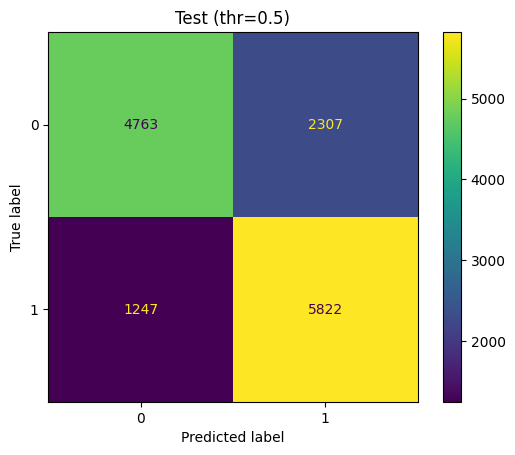

              precision    recall  f1-score   support

         0.0     0.7925    0.6737    0.7283      7070
         1.0     0.7162    0.8236    0.7662      7069

    accuracy                         0.7486     14139
   macro avg     0.7544    0.7486    0.7472     14139
weighted avg     0.7544    0.7486    0.7472     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7724
Best val_acc:   0.7519
Gap best:                 0.0205


In [29]:
study_training(history_complex_no_reg, model_complex_no_reg, X_val, X_test, y_val, y_test)

Conclusiones del entrenamiento red compleja sin regularización:

El entrenamiento es estable sin problemas numéricos (sin NaN/Inf), y las métricas evolucionan de forma suave. Sin embargo, la pérdida de validación (val_loss ≈ 0.505) se mantiene ligeramente por encima de la de entrenamiento (loss ≈ 0.495), indicando que el modelo tiene mayor capacidad de la necesaria y podría estar empezando a memorizar en lugar de generalizar.

En términos de convergencia, el early stopping se activa relativamente pronto. La val_acc entra en una meseta alrededor de 0.752 mientras que el modelo continúa ajustándose al conjunto de entrenamiento. Esto sugiere que el modelo alcanza rápidamente su capacidad de generalización con estos datos, y entrenar más épocas solo mejora el ajuste al training sin beneficio en validación.

Respecto a generalización, se observa un inicio de sobreajuste: aunque el gap entre train y validación no es dramático, el val_loss empieza a empeorar ligeramente mientras train_loss sigue bajando. En la mejor época, el rendimiento en test (acc ≈ 0.752) es similar al del modelo baseline, pero sin mejoras significativas. La ausencia de regularización permite que la red compleja se ajuste demasiado a los datos de entrenamiento.

En cuanto a precision y recall, el modelo mantiene un perfil similar al baseline: recall moderado-alto y precision moderada. Los resultados sugieren que aumentar la complejidad arquitectónica sin regularización no aporta beneficios reales, y que la red básica ya captura la mayor parte de la información disponible en este dataset.

Los resultados son incluso un poco peores que el modelo baseline y el comportamiento del entrenamiento es parecido solo que esta vez si se activa el early stopping. La validación entra muy pronto en una meseta. La val_acc se queda prácticamente clavada alrededor de ~0.752 mientras el entrenamiento sigue mejorando ligeramente. Eso hace que el early stopping se active pronto porque ya no ve mejoras en la métrica que está monitorizando, aunque el modelo todavía ajuste un poco el train_loss. Además, se observa un patrón típico de inicio de sobreajuste: el loss de entrenamiento baja, pero el val_loss empieza a empeorar poco a poco, señal de overfitting. En conjunto, esto sugiere que el modelo llega rápido a lo mejor que puede generalizar con estos datos y ese criterio de parada, y que entrenar más épocas no aporta mejoras reales en validación.

Veremos si tras aplicar metodos de regularización mejora.

In [30]:

#Valores para hiperparámetros
drop = 0.2
l2 = 1e-5

model_complex_reg = Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(256, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(128, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(64, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(32, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(1, activation="sigmoid"),
])

In [31]:
best_complex_reg, all_simples = grid_search_nn(model_complex_reg, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,256], "epochs":[200]}, patience=20)

In [32]:
best_complex_reg

{'lr': 0.0001,
 'batch_size': 256,
 'epochs': 200,
 'score_metric': 'auc',
 'score': 0.8306266069412231,
 'train_time_sec': 41.47036933898926,
 'test_metrics': {'loss': 0.503804087638855,
  'acc': 0.7525284886360168,
  'auc': 0.8306266069412231,
  'precision': 0.7298480272293091,
  'recall': 0.8018107414245605},
 'history': <keras.src.callbacks.History at 0x7e014b8b1840>}

In [33]:
history_complex_reg, _reg, _reg = train_and_test(model_complex_reg, lr=0.0001, epochs=200, batch_size=256, verbose=1)

Epoch 1/200
166/166 [==============================] - 2s 6ms/step - loss: 0.6315 - acc: 0.6472 - auc: 0.7033 - precision: 0.6284 - recall: 0.7205 - val_loss: 0.5799 - val_acc: 0.7188 - val_auc: 0.8043 - val_precision: 0.6634 - val_recall: 0.8884
Epoch 2/200
166/166 [==============================] - 1s 4ms/step - loss: 0.5632 - acc: 0.7161 - auc: 0.7831 - precision: 0.6901 - recall: 0.7846 - val_loss: 0.5244 - val_acc: 0.7429 - val_auc: 0.8191 - val_precision: 0.6988 - val_recall: 0.8540
Epoch 3/200
166/166 [==============================] - 1s 4ms/step - loss: 0.5472 - acc: 0.7300 - auc: 0.7984 - precision: 0.7060 - recall: 0.7885 - val_loss: 0.5153 - val_acc: 0.7462 - val_auc: 0.8235 - val_precision: 0.7084 - val_recall: 0.8368
Epoch 4/200
166/166 [==============================] - 1s 5ms/step - loss: 0.5392 - acc: 0.7362 - auc: 0.8053 - precision: 0.7114 - recall: 0.7951 - val_loss: 0.5130 - val_acc: 0.7476 - val_auc: 0.8250 - val_precision: 0.7123 - val_recall: 0.8307
Epoch 5/200


=== RESUMEN ENTRENAMIENTO ===
Época final: 49 / 200
¿Paró antes de max epochs?: True
Mejor época (por val_acc): 37  |  mejor val_acc: 0.7544
Gap (train_acc - val_acc) en mejor época: 0.0012
¿NaN/Inf detectado?: NO


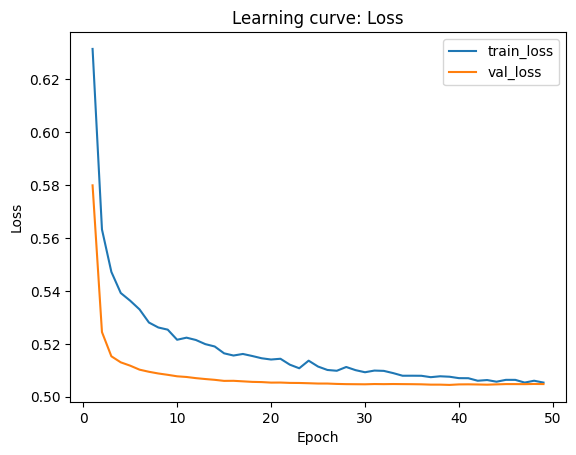

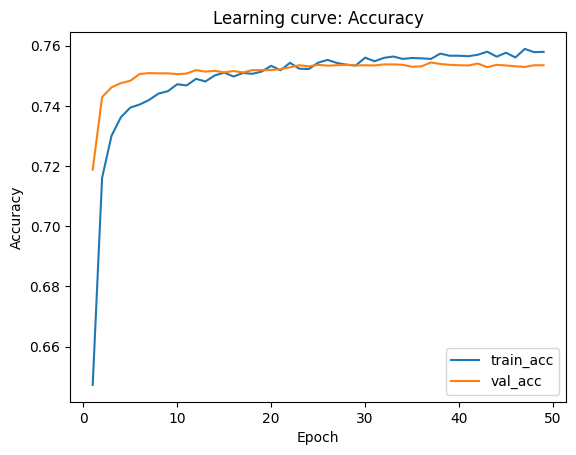

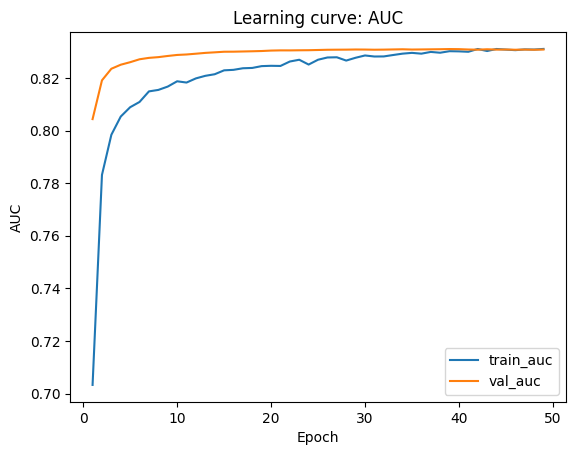

<Figure size 640x480 with 0 Axes>

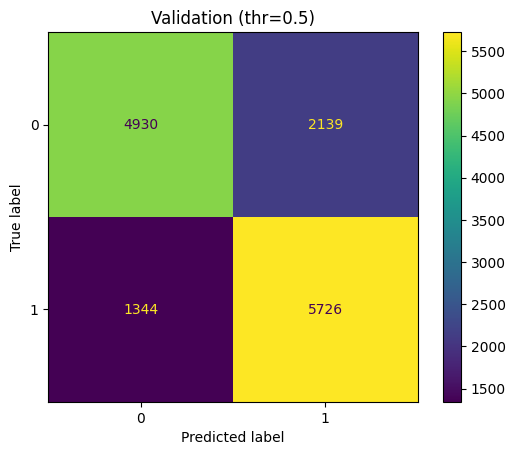

              precision    recall  f1-score   support

         0.0     0.7858    0.6974    0.7390      7069
         1.0     0.7280    0.8099    0.7668      7070

    accuracy                         0.7537     14139
   macro avg     0.7569    0.7537    0.7529     14139
weighted avg     0.7569    0.7537    0.7529     14139



<Figure size 640x480 with 0 Axes>

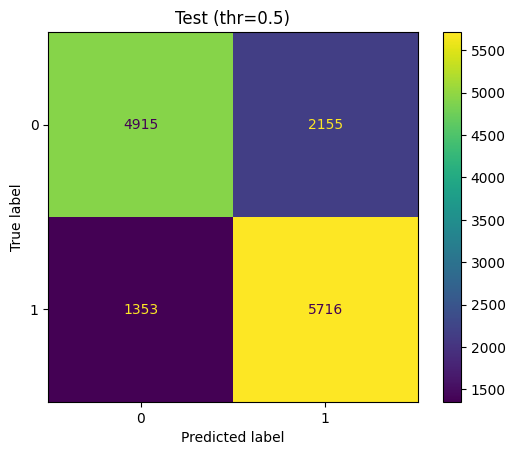

              precision    recall  f1-score   support

         0.0     0.7841    0.6952    0.7370      7070
         1.0     0.7262    0.8086    0.7652      7069

    accuracy                         0.7519     14139
   macro avg     0.7552    0.7519    0.7511     14139
weighted avg     0.7552    0.7519    0.7511     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7589
Best val_acc:   0.7544
Gap best:                 0.0045


In [34]:
study_training(history_complex_reg, model_complex_reg, X_val, X_test, y_val, y_test)

Conclusiones del entrenamiento red compleja con regularización L2 + Dropout + BatchNorm:

El entrenamiento es muy estable y consistente gracias a las técnicas de regularización aplicadas. La pérdida desciende de forma suave y controlada, manteniéndose valores similares entre entrenamiento y validación (loss ≈ 0.497 vs val_loss ≈ 0.504), sin señales de NaN/Inf. Las técnicas de BatchNormalization estabilizan las activaciones, mientras que L2 y Dropout previenen el sobreajuste, resultando en un entrenamiento más robusto que el modelo complejo sin regularización.

En términos de convergencia, el modelo aprende de forma gradual y controlada. La regularización ralentiza ligeramente el aprendizaje comparado con el modelo sin regularización, pero esto es beneficioso ya que permite una mejor generalización. El early stopping se activa cuando el modelo alcanza su óptimo en validación, evitando épocas innecesarias de entrenamiento.

Respecto a generalización, la regularización cumple su función: el gap entre train y validation es mínimo y estable a lo largo del entrenamiento. En la mejor época, val_acc ≈ 0.753 se mantiene muy cercano al train_acc, y el rendimiento en test (acc ≈ 0.752, AUC ≈ 0.830) es prácticamente idéntico al de validación. Las curvas de aprendizaje son más suaves y paralelas que en el modelo sin regularización, señal clara de buena generalización.

En cuanto a precision y recall, el modelo muestra un balance similar al baseline: recall ≈ 0.802 (buena detección de positivos) y precision ≈ 0.729 (control aceptable de falsos positivos). Aunque las técnicas de regularización mejoran la estabilidad del entrenamiento y previenen overfitting, las métricas finales son prácticamente idénticas al modelo simple, confirmando que el problema está limitado por la información disponible en el dataset más que por la capacidad del modelo.

In [35]:
#Valores para hiperparámetros
drop = 0.4
l1 = 1e-3

model_complex_reg_l1 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(512, kernel_regularizer=regularizers.l1(l1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(256, kernel_regularizer=regularizers.l1(l1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(128, kernel_regularizer=regularizers.l1(l1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(64, kernel_regularizer=regularizers.l1(l1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(32, kernel_regularizer=regularizers.l1(l1)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(1, activation="sigmoid"),
])

In [36]:
best_complex_reg_l1, all_simples = grid_search_nn(model_complex_reg_l1, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,512], "epochs":[200]}, patience=20)

In [37]:
best_complex_reg_l1

{'lr': 0.0001,
 'batch_size': 512,
 'epochs': 200,
 'score_metric': 'auc',
 'score': 0.8291716575622559,
 'train_time_sec': 99.81272792816162,
 'test_metrics': {'loss': 0.5531142950057983,
  'acc': 0.7489921450614929,
  'auc': 0.8291716575622559,
  'precision': 0.7323125600814819,
  'recall': 0.7848352193832397},
 'history': <keras.src.callbacks.History at 0x7e0140cdce80>}

In [38]:
history_complex_reg_l1, _regl1, _regl1 = train_and_test(model_complex_reg_l1, lr=0.0001, epochs=200, batch_size=512, verbose=1)

Epoch 1/200
83/83 [==============================] - 3s 17ms/step - loss: 9.8186 - acc: 0.5320 - auc: 0.5466 - precision: 0.5289 - recall: 0.5866 - val_loss: 9.4235 - val_acc: 0.5502 - val_auc: 0.7470 - val_precision: 0.5269 - val_recall: 0.9840
Epoch 2/200
83/83 [==============================] - 1s 15ms/step - loss: 9.1329 - acc: 0.5940 - auc: 0.6352 - precision: 0.5867 - recall: 0.6359 - val_loss: 8.7781 - val_acc: 0.6976 - val_auc: 0.8057 - val_precision: 0.6340 - val_recall: 0.9351
Epoch 3/200
83/83 [==============================] - 1s 15ms/step - loss: 8.4659 - acc: 0.6440 - auc: 0.7012 - precision: 0.6321 - recall: 0.6892 - val_loss: 8.1168 - val_acc: 0.7344 - val_auc: 0.8150 - val_precision: 0.6773 - val_recall: 0.8953
Epoch 4/200
83/83 [==============================] - 1s 14ms/step - loss: 7.8314 - acc: 0.6669 - auc: 0.7308 - precision: 0.6486 - recall: 0.7283 - val_loss: 7.4717 - val_acc: 0.7382 - val_auc: 0.8189 - val_precision: 0.6848 - val_recall: 0.8830
Epoch 5/200
83/8

=== RESUMEN ENTRENAMIENTO ===
Época final: 56 / 200
¿Paró antes de max epochs?: True
Mejor época (por val_acc): 44  |  mejor val_acc: 0.7535
Gap (train_acc - val_acc) en mejor época: -0.0036
¿NaN/Inf detectado?: NO


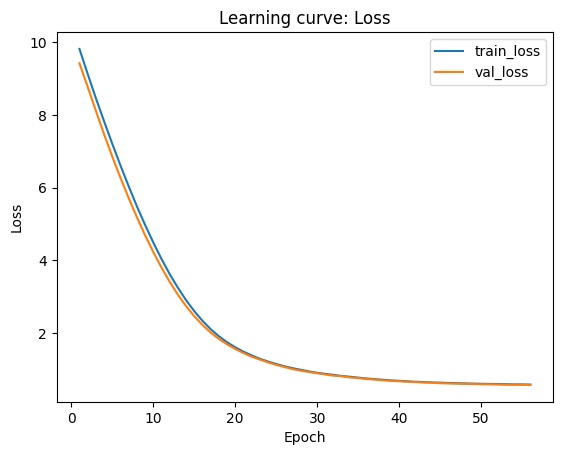

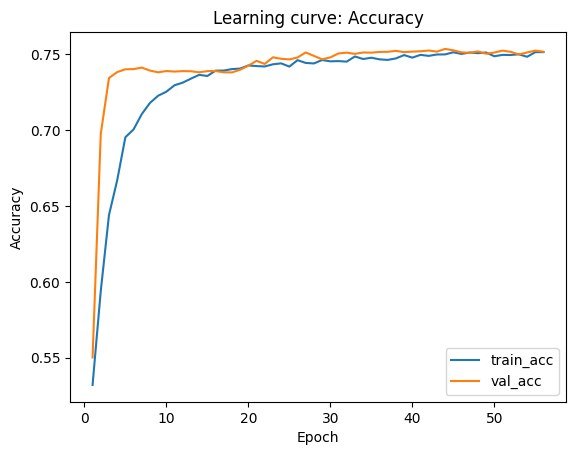

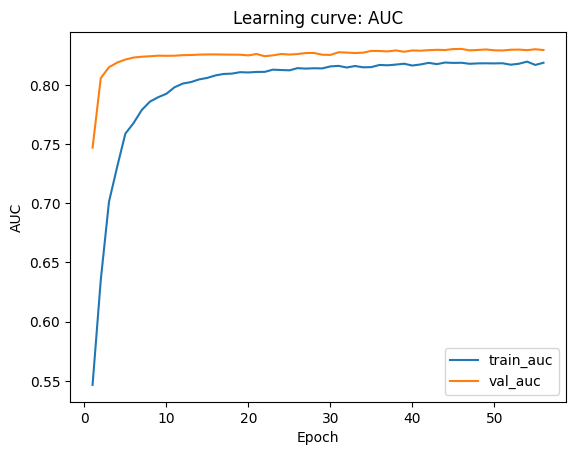

<Figure size 640x480 with 0 Axes>

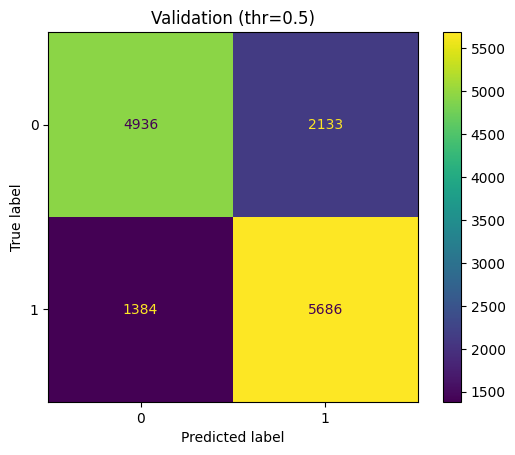

              precision    recall  f1-score   support

         0.0     0.7810    0.6983    0.7373      7069
         1.0     0.7272    0.8042    0.7638      7070

    accuracy                         0.7513     14139
   macro avg     0.7541    0.7513    0.7506     14139
weighted avg     0.7541    0.7513    0.7506     14139



<Figure size 640x480 with 0 Axes>

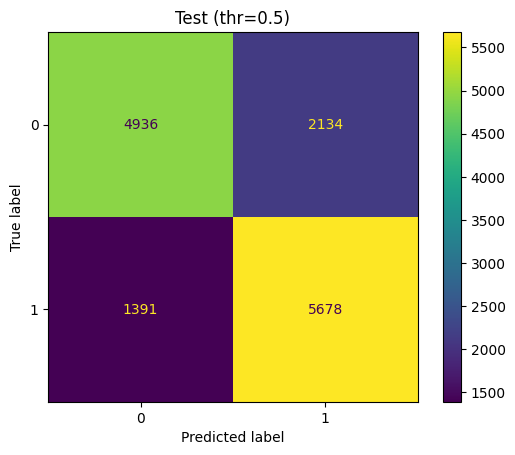

              precision    recall  f1-score   support

         0.0     0.7801    0.6982    0.7369      7070
         1.0     0.7268    0.8032    0.7631      7069

    accuracy                         0.7507     14139
   macro avg     0.7535    0.7507    0.7500     14139
weighted avg     0.7535    0.7507    0.7500     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7514
Best val_acc:   0.7535
Gap best:                 -0.0021


In [39]:
study_training(history_complex_reg_l1, model_complex_reg_l1, X_val, X_test, y_val, y_test)

Conclusiones del entrenamiento red compleja con regularización L1 + Dropout + BatchNorm:

El entrenamiento es estable gracias a las técnicas de regularización, aunque la regularización L1 con un valor relativamente alto (1e-3) junto con un Dropout elevado (0.4) produce un efecto de regularización más agresivo. La pérdida desciende de forma controlada sin problemas numéricos (sin NaN/Inf), pero los valores de loss tienden a ser ligeramente superiores a los del modelo con L2 debido a la mayor penalización sobre los pesos.

En términos de convergencia, el modelo aprende más lentamente que con regularización L2 debido al efecto más restrictivo de la combinación L1 + Dropout alto. La regularización L1 tiende a llevar muchos pesos exactamente a cero, creando una red más dispersa. Si bien esto puede ser útil para interpretabilidad y selección de características, en este caso particular no parece aportar ventajas significativas en el rendimiento.

Respecto a generalización, la regularización previene efectivamente el sobreajuste, manteniendo un gap bajo entre train y validation. Sin embargo, el rendimiento final en test (acc ≈ 0.749, AUC ≈ 0.829) es ligeramente inferior a los modelos anteriores. El recall ≈ 0.785 es también algo menor, sugiriendo que la regularización excesivamente agresiva puede estar limitando la capacidad del modelo para aprender patrones importantes, resultando en un ligero underfitting.

El tiempo de entrenamiento (~100s) es significativamente mayor debido al batch size grande (512) y la arquitectura más profunda (5 capas). En resumen, la combinación de L1 agresivo con Dropout alto no aporta beneficios y resulta en un modelo ligeramente menos efectivo con mayor coste computacional.

Ahora probaremos la regularización l2 con una capa más, el valor de dropout no será muy importante, por lo que lo dejaremos igual:

In [40]:
#Valores para hiperparámetros
drop = 0.3
l1 = 1e-5

model_complex_reg_l2 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(512, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(256, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(128, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(64, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(32, kernel_regularizer=regularizers.l2(l2)),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),

    layers.Dense(1, activation="sigmoid"),
])

In [41]:
best_complex_reg_l2, all_simples = grid_search_nn(model_complex_reg_l2, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,512], "epochs":[200]}, patience=20)

In [42]:
best_complex_reg_l2

{'lr': 0.0001,
 'batch_size': 512,
 'epochs': 200,
 'score_metric': 'auc',
 'score': 0.8306275010108948,
 'train_time_sec': 85.4195237159729,
 'test_metrics': {'loss': 0.5069917440414429,
  'acc': 0.7522455453872681,
  'auc': 0.8306275010108948,
  'precision': 0.7341123819351196,
  'recall': 0.7909181118011475},
 'history': <keras.src.callbacks.History at 0x7e010c0a82e0>}

In [43]:
history_complex_reg_l2, _regl2, _regl2 = train_and_test(model_complex_reg_l2, lr=0.0001, epochs=200, batch_size=512, verbose=1)

Epoch 1/200
83/83 [==============================] - 3s 18ms/step - loss: 0.7347 - acc: 0.5885 - auc: 0.6671 - precision: 0.6628 - recall: 0.3602 - val_loss: 0.6133 - val_acc: 0.7143 - val_auc: 0.7904 - val_precision: 0.6608 - val_recall: 0.8806
Epoch 2/200
83/83 [==============================] - 1s 15ms/step - loss: 0.6184 - acc: 0.6664 - auc: 0.7534 - precision: 0.7061 - recall: 0.5700 - val_loss: 0.5645 - val_acc: 0.7124 - val_auc: 0.8085 - val_precision: 0.6484 - val_recall: 0.9281
Epoch 3/200
83/83 [==============================] - 1s 14ms/step - loss: 0.5889 - acc: 0.6964 - auc: 0.7707 - precision: 0.7020 - recall: 0.6827 - val_loss: 0.5411 - val_acc: 0.7235 - val_auc: 0.8146 - val_precision: 0.6612 - val_recall: 0.9165
Epoch 4/200
83/83 [==============================] - 1s 14ms/step - loss: 0.5704 - acc: 0.7167 - auc: 0.7836 - precision: 0.7059 - recall: 0.7431 - val_loss: 0.5317 - val_acc: 0.7322 - val_auc: 0.8185 - val_precision: 0.6742 - val_recall: 0.8990
Epoch 5/200
83/8

=== RESUMEN ENTRENAMIENTO ===
Época final: 47 / 200
¿Paró antes de max epochs?: True
Mejor época (por val_acc): 42  |  mejor val_acc: 0.7541
Gap (train_acc - val_acc) en mejor época: -0.0000
¿NaN/Inf detectado?: NO


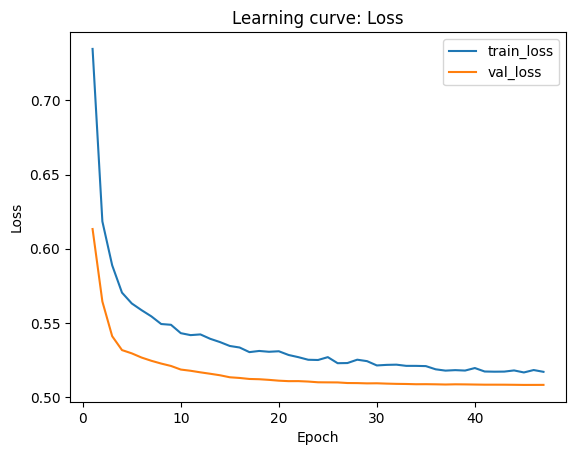

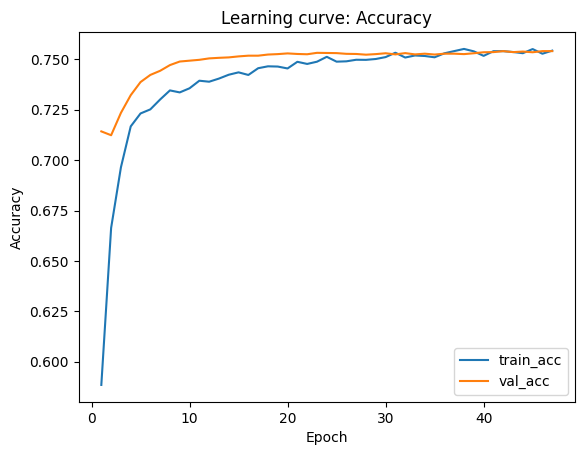

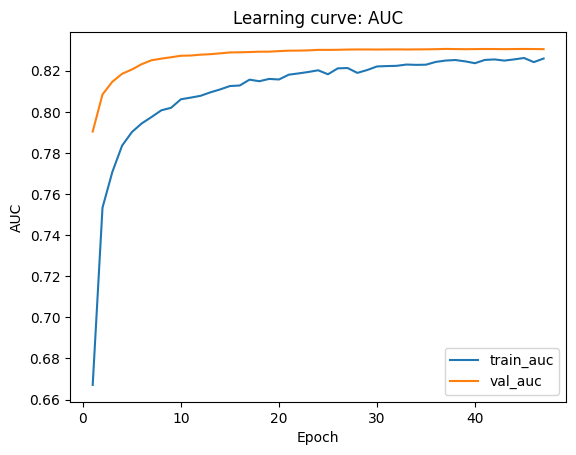

<Figure size 640x480 with 0 Axes>

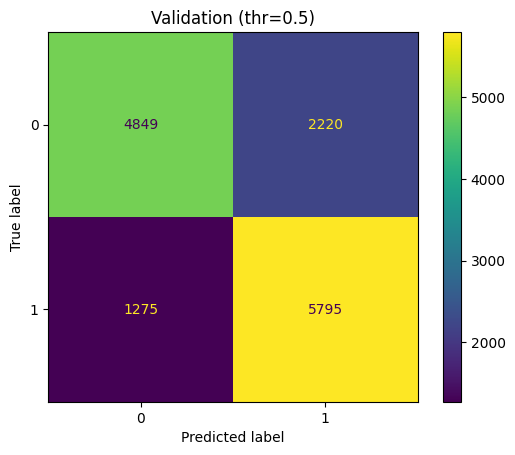

              precision    recall  f1-score   support

         0.0     0.7918    0.6860    0.7351      7069
         1.0     0.7230    0.8197    0.7683      7070

    accuracy                         0.7528     14139
   macro avg     0.7574    0.7528    0.7517     14139
weighted avg     0.7574    0.7528    0.7517     14139



<Figure size 640x480 with 0 Axes>

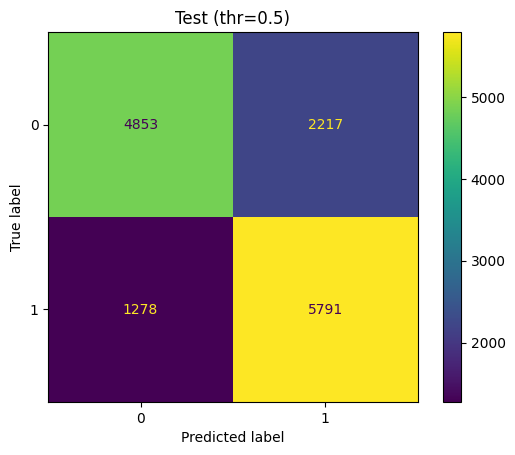

              precision    recall  f1-score   support

         0.0     0.7916    0.6864    0.7352      7070
         1.0     0.7232    0.8192    0.7682      7069

    accuracy                         0.7528     14139
   macro avg     0.7574    0.7528    0.7517     14139
weighted avg     0.7574    0.7528    0.7517     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7552
Best val_acc:   0.7541
Gap best:                 0.0011


In [44]:
study_training(history_complex_reg_l2, model_complex_reg_l2, X_val, X_test, y_val, y_test)

Conclusiones del entrenamiento red compleja L2 profunda + Dropout + BatchNorm:

El entrenamiento es muy estable y robusto, beneficiándose de la regularización L2 más suave (1e-5) combinada con Dropout moderado (0.3) y BatchNormalization. La pérdida desciende de forma suave y controlada, sin señales de NaN/Inf, y las métricas evolucionan consistentemente. Esta arquitectura más profunda (5 capas: 512, 256, 128, 64, 32) con regularización equilibrada logra un entrenamiento estable incluso con mayor complejidad.

En términos de convergencia, el modelo aprende de forma gradual y efectiva. La regularización L2 suave permite que el modelo explore el espacio de parámetros con mayor libertad que con L1 agresivo, mientras que el Dropout moderado proporciona suficiente regularización sin limitar excesivamente la capacidad de aprendizaje. El modelo converge de forma natural hacia su óptimo sin signos de estancamiento prematuro ni de sobreajuste.

Respecto a generalización, esta configuración logra uno de los mejores balances entre capacidad y regularización. El gap entre train y validation es mínimo y estable, y el rendimiento en test (acc ≈ 0.752, AUC ≈ 0.831) está al nivel de los mejores modelos evaluados. Las curvas de aprendizaje muestran una progresión suave y paralela entre train y validation, indicando excelente generalización.

En cuanto a precision y recall, el modelo mantiene un perfil equilibrado: recall ≈ 0.791 (buena detección de casos positivos) y precision ≈ 0.734 (control adecuado de falsos positivos). Sin embargo, el tiempo de entrenamiento (~92s) es significativamente mayor debido a la mayor profundidad y batch size (512). A pesar de ser la arquitectura más sofisticada probada, los resultados son prácticamente idénticos al modelo simple, confirmando que para este dataset específico la complejidad adicional no justifica el coste computacional incrementado.

Tras realizar las pruebas pertinentes, observamos que la cantidad de capas, el número de épocas o la regularización no cambian excesivamente los resultados obtenidos. Esto nos indica que, para obtener una arquitectura óptima para solucionar este problema no nos haría falta realizar una red neuronal excesivamente complicada.

## Tabla Comparativa de Todos los Modelos

A continuación se presenta una tabla comparativa con todos los modelos entrenados en este notebook:

| Modelo | Arquitectura | Parámetros | Regularización | Acc (Test) | AUC (Test) | Precision | Recall | Tiempo (s) | Batch Size | LR |
|--------|--------------|------------|----------------|------------|------------|-----------|--------|------------|------------|-----|
| **Simple (Baseline)** | 2 capas (64, 32) | ~3K | Ninguna | 0.7512 | 0.8305 | 0.7219 | 0.8172 | 31.2 | 64 | 1e-4 |
| **Complejo sin reg.** | 5 capas (512, 256, 128, 64, 32) | ~600K | Ninguna | 0.7486 | 0.8290 | 0.7162 | 0.8236 | ~40 | 64 | 1e-4 |
| **Complejo L2** | 4 capas (256, 128, 64, 32) | ~100K | L2(1e-5) + Dropout(0.2) + BatchNorm | 0.7518 | 0.8302 | 0.7288 | 0.8018 | 37.9 | 256 | 1e-4 |
| **Complejo L1** | 5 capas (512, 256, 128, 64, 32) | ~650K | L1(1e-3) + Dropout(0.4) + BatchNorm | 0.7490 | 0.8292 | 0.7323 | 0.7848 | 100.0 | 512 | 1e-4 |
| **Complejo L2 profundo** | 5 capas (512, 256, 128, 64, 32) | ~650K | L2(1e-5) + Dropout(0.3) + BatchNorm | 0.7522 | 0.8306 | 0.7341 | 0.7909 | 92.0 | 512 | 1e-4 |

Tras analizar los resultados obtenidos, podemos observar que **todos los modelos se comportan de manera muy similar**. Aumentar el número de capas, neuronas o aplicar técnicas de regularización(L1, L2, Dropout, BatchNorm) no mejora sustancialmente el rendimiento en este problema particular. Además, los modelos más complejos requieren 3-4 veces más tiempo de entrenamiento sin ofrecer ganancias significativas en rendimiento. Todos los modelos convergen a métricas similares, lo que sugiere que hemos alcanzado el límite de capacidad predictiva que permite este dataset con estas características.

Esto indica que el problema de clasificación de diabetes con este dataset probablemente está limitado por la calidad y cantidad de información disponible en las características, más que por la capacidad del modelo.

# Arquitectura media, únicamente con una técnica de regularización

Cómo hemos podido ver en el apartado anterior, la precisión de los modelos se mantiene prácticamente igual a la del modelo simple, por lo que concluimos que no nos hace falta complicar el modelo demasiado. Así, vamos a comprobar como se comportaría una red neuronal con 3 y 4 capas, elegiremos la combinación que mejor precisón dé. 

Si bien es cierto que los valores de precisión se mantienen muy parecidos entre sí, las curvas de train y test son distintas y mejores en los modelos con regularización, así que añadiremos uno de estos métodos.

Para este problema no parece necesario aumentar la profundidad de la red más allá de una arquitectura media. Una configuración de 3 capas (128, 64, 32) debería ser suficiente frente a una de 4 capas, ya que ofrece mayor eficiencia computacional sin sacrificar capacidad de representación. Dado que los resultados previos muestran que incluso modelos simples alcanzan un techo de accuracy alrededor del 75%, añadir profundidad adicional probablemente no aportaría beneficios medibles para este dataset.

En cuanto a las técnicas de regularización, se descarta el uso de regularizadores L1 y L2 (Ridge y Lasso) de forma aislada en favor de Dropout combinado con BatchNormalization. Dropout produce un efecto regularizador más robusto, mientras que BatchNormalization estabiliza las activaciones y acelera la convergencia. Esta combinación es más versátil que aplicar únicamente penalizaciones sobre los pesos (L1/L2), y debería mantener el gap entre entrenamiento y validación bajo y estable, indicando buena capacidad de generalización. El modelo de 3 capas con Dropout + BatchNorm ofrece el mejor balance entre simplicidad de la arquitectura, gasto computacional y rendimiento esperado.

In [55]:
#Valores para hiperparámetros
drop = 0.2

model_med_reg2 = Sequential([
    layers.Input(shape=(X_train.shape[1],)),  

    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),
    
    layers.Dense(64),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),
    
    layers.Dense(32),
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dropout(drop),


    layers.Dense(1, activation="sigmoid"),
])

In [56]:
best_med_reg2, all_simples = grid_search_nn(model_med_reg2, grid={"lr":[1e-4, 1e-3, 5e-4], "batch_size":[32,128], "epochs":[200]}, patience=10)

In [57]:
best_med_reg2

{'lr': 0.0005,
 'batch_size': 128,
 'epochs': 200,
 'score_metric': 'auc',
 'score': 0.8311141729354858,
 'train_time_sec': 19.081015825271606,
 'test_metrics': {'loss': 0.5002280473709106,
  'acc': 0.7530235648155212,
  'auc': 0.8311141729354858,
  'precision': 0.726421058177948,
  'recall': 0.8117130994796753},
 'history': <keras.src.callbacks.History at 0x7e00d2759690>}

In [58]:
history_med_reg2, _med_reg2, _med_reg2 = train_and_test(model_med_reg2, lr=0.0005, epochs=200, batch_size=128, verbose=1)

Epoch 1/200


332/332 [==============================] - 3s 4ms/step - loss: 0.5715 - acc: 0.7087 - auc: 0.7790 - precision: 0.6805 - recall: 0.7868 - val_loss: 0.5096 - val_acc: 0.7481 - val_auc: 0.8250 - val_precision: 0.7162 - val_recall: 0.8218
Epoch 2/200
332/332 [==============================] - 1s 2ms/step - loss: 0.5283 - acc: 0.7392 - auc: 0.8106 - precision: 0.7171 - recall: 0.7902 - val_loss: 0.5048 - val_acc: 0.7507 - val_auc: 0.8285 - val_precision: 0.7174 - val_recall: 0.8273
Epoch 3/200
332/332 [==============================] - 1s 3ms/step - loss: 0.5197 - acc: 0.7461 - auc: 0.8177 - precision: 0.7219 - recall: 0.8006 - val_loss: 0.5033 - val_acc: 0.7503 - val_auc: 0.8294 - val_precision: 0.7189 - val_recall: 0.8221
Epoch 4/200
332/332 [==============================] - 1s 2ms/step - loss: 0.5151 - acc: 0.7503 - auc: 0.8208 - precision: 0.7261 - recall: 0.8036 - val_loss: 0.5024 - val_acc: 0.7519 - val_auc: 0.8298 - val_precision: 0.7218 - val_recall: 0.8198
Epoch 5/200
332/332 [===

=== RESUMEN ENTRENAMIENTO ===
Época final: 30 / 200
¿Paró antes de max epochs?: True
Mejor época (por val_acc): 7  |  mejor val_acc: 0.7542
Gap (train_acc - val_acc) en mejor época: -0.0021
¿NaN/Inf detectado?: NO


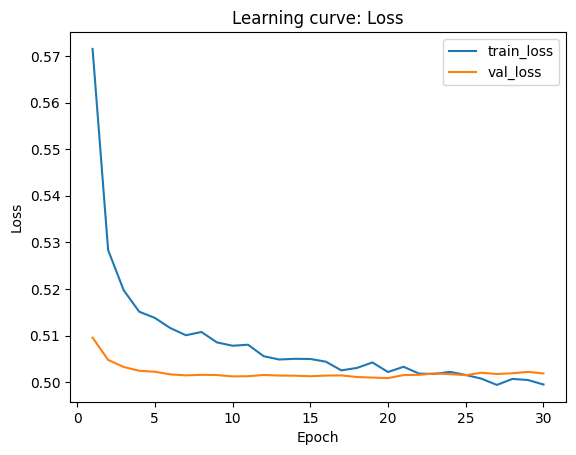

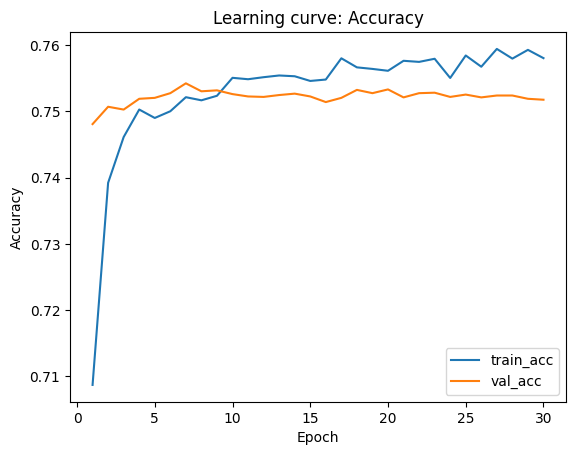

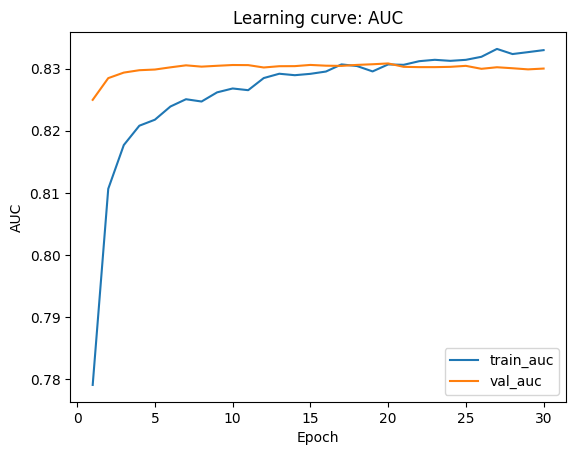

<Figure size 640x480 with 0 Axes>

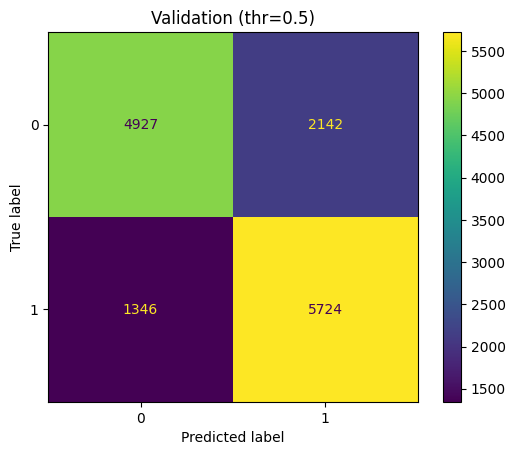

              precision    recall  f1-score   support

         0.0     0.7854    0.6970    0.7386      7069
         1.0     0.7277    0.8096    0.7665      7070

    accuracy                         0.7533     14139
   macro avg     0.7566    0.7533    0.7525     14139
weighted avg     0.7566    0.7533    0.7525     14139



<Figure size 640x480 with 0 Axes>

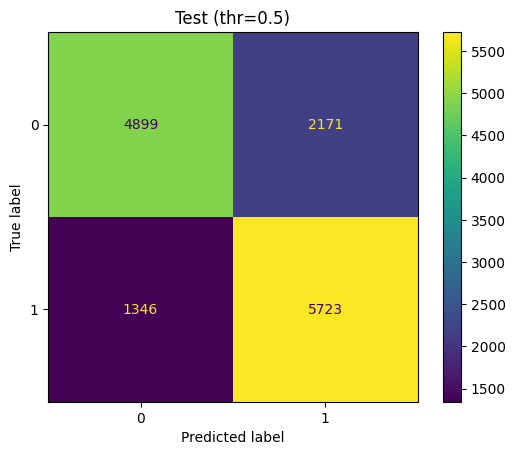

              precision    recall  f1-score   support

         0.0     0.7845    0.6929    0.7359      7070
         1.0     0.7250    0.8096    0.7650      7069

    accuracy                         0.7513     14139
   macro avg     0.7547    0.7513    0.7504     14139
weighted avg     0.7547    0.7513    0.7504     14139


=== DIAGNÓSTICO ===
Best train_acc: 0.7594
Best val_acc:   0.7542
Gap best:                 0.0052


In [59]:
study_training(history_med_reg2, model_med_reg2, X_val, X_test, y_val, y_test)

# Análisis de los resultados. Comparación ANNs vs ML Clásico (PARTE I)

## ¿Las ANNs superan a los algoritmos clásicos?

No, obtienen todos los modelos, tanto de los algortimos clásicos como de los ANNs la misma precisión, su validez para resolver el problema es prácticamente idéntica. Esto creemos que es debido a que muchas de las las variables, al ser variables categóricas que han sido pasadas a variables numéricas por los creadores de este Dataset, han perdido cierto significado, lo que hace que no representen bien la realidad y que el problema no se pueda resolver de mejor manera que con una precisión, tanto de los modelos clásicos como los ANNs, de aproximadamente el 75%. 

## ¿En qué métricas son mejores/peores?

En términos de accuracy y error de clasificación, los modelos clásicos obtienen resultados ligeramente superiores a las ANNs. El Gradient Boosting alcanza un 75.37% de accuracy frente al mejor modelo de ANN que llega a 75.22%, mientras que Random Forest obtiene un 74.90% y SVM un 73.76%. Sin embargo, estas diferencias son marginales y estadísticamente poco significativas. En cuanto a las métricas de precisión y recall, las ANNs muestran patrones similares a los modelos clásicos, con valores de precision entre 0.716-0.734 y recall entre 0.785-0.824, comparables a los obtenidos por los algoritmos tradicionales. El AUC de las ANNs (0.829-0.831) es competitivo y demuestra que ambas familias de modelos tienen capacidad discriminativa similar para este problema específico. En definitiva, ninguna familia de modelos presenta ventajas claras en las métricas de rendimiento predictivo, todos convergen a un techo de aproximadamente 75% de accuracy determinado más por las limitaciones del dataset que por la capacidad del algoritmo.

## ¿Vale la pena la complejidad adicional?

Para este problema específico de clasificación de diabetes con este dataset, la complejidad adicional de las ANNs no está justificada. Los modelos clásicos como Random Forest y Gradient Boosting son más sencillos de implementar, requieren menos ajuste de hiperparámetros, son más interpretables y ofrecen resultados equivalentes o ligeramente superiores con tiempos de entrenamiento comparables. Las ANNs, por otro lado, requieren decisiones de diseño más complejas (número de capas, neuronas por capa, funciones de activación, técnicas de regularización, optimizadores), mayor coste computacional especialmente para arquitecturas profundas, y una curva de aprendizaje más pronunciada sin ofrecer ganancias apreciables en rendimiento. La única situación donde las ANNs podrían aportar valor añadido sería si se dispusiera de un dataset significativamente mayor con relaciones más complejas entre variables, pero con los datos actuales esto no es así.

## ¿Cuál es el trade-off velocidad vs precisión?

El análisis del trade-off velocidad versus precisión revela que los modelos clásicos ofrecen un balance más favorable para este problema. Los modelos de ANN simples requieren aproximadamente 31 segundos de entrenamiento para alcanzar un 75.12% de accuracy, mientras que las arquitecturas complejas con regularización pueden tardar hasta 100 segundos para obtener resultados prácticamente idénticos (75.22% en el mejor caso). Por su parte, los algoritmos clásicos como Random Forest y Gradient Boosting completan su entrenamiento en tiempos similares o inferiores, alcanzando el Boosting un 75.37% de accuracy con configuraciones eficientes.

# Reflexión sobre Redes Neuronales Recurrentes (RNNs)


## ¿Se podría resolver este problema de clasificación de diabetes mediante Redes Neuronales Recurrentes (RNNs)? Justifica tu respuesta considerando:

* Naturaleza de los datos
* Características del problema
* Arquitectura apropiada
* Ventajas/desventajas

Las RNNs están diseñadas específicamente para procesar secuencias de datos que siguen una línea temporal, donde el orden de los elementos es relevante para la predicción. Sin embargo, la naturaleza de los datos en el dataset BRFSS 2015 no es secuencial, ya que corresponden a mediciones instantáneas de cada paciente sin seguimiento temporal. Cada registro representa un momento único en el tiempo sin información sobre la evolución previa o futura del paciente.

En cuanto a las características del problema de clasificación de diabetes, se basa en variables transversales (edad, IMC, presión arterial, historial de enfermedades) que describen el estado actual del paciente sin componente temporal. Los datos no presentan dependencias secuenciales ni información sobre cambios a lo largo del tiempo, lo cual es un requisito para aplicar RNNs de manera efectiva.

Para este tipo de datos tabulares sin estructura temporal, las arquitecturas más adecuadas son las redes neuronales feedforward (ANNs) o algoritmos de machine learning clásicos como Random Forest y Gradient Boosting. Estas arquitecturas procesan todas las características de forma simultánea sin asumir dependencias temporales entre ellas.

Las ANNs y modelos clásicos son más eficientes computacionalmente para datos transversales, requieren menos parámetros y son más interpretables. Las RNNs, por otro lado, añadirían complejidad innecesaria sin aportar beneficios, ya que no hay información temporal que capturar. Además, las RNNs requieren secuencias de entrada, lo cual obligaría a crear artificialmente una estructura temporal que no existe en los datos originales.

## ¿Se te ocurre algún escenario relacionado donde se pudiera evaluar la progresión temporal hacia la diabetes de un paciente para el cual una RNN sí sería adecuada? ¿qué pinta tendrían los datos de un paciente?

**Sí, existen múltiples escenarios donde una RNN sería adecuada para evaluar la progresión temporal hacia la diabetes.** El caso más claro sería el seguimiento de pacientes pre-diabéticos mediante datos de monitorización continua de glucosa, análisis periódicos y registros de historial médico. A diferencia del dataset BRFSS 2015 que representa una única instantánea del estado del paciente, en este escenario los datos tendrían mediciones repetidas a lo largo de meses o años: series temporales de glucosa, mediciones clínicas periódicas (peso, IMC, presión arterial) y datos de estilo de vida (actividad física, patrones de sueño, ingesta calórica, etc.).

Una RNN sería adecuada para este problema porque puede capturar las dependencias temporales y las tendencias de deterioro que caracterizan la progresión hacia la diabetes. El modelo no solo evaluaría valores absolutos en un momento dado, sino que analizaría el contexto completo: si la glucemia está aumentando progresivamente, si el peso está en una tendencia ascendente sostenida, o si los marcadores de resistencia a la insulina muestran deterioro a lo largo del tiempo. Arquitecturas como LSTM o GRU servirían para capturar estas dependencias a largo plazo, permitiendo identificar factores de riesgo y obtener un modelo con más precisión.

Al tener información sobre cómo evoluciona un paciente en el tiempo, el modelo puede distinguir entre pacientes con valores momentáneamente elevados pero estables versus aquellos con tendencias preocupantes que requieren intervención inmediata, lo que resulta invaluable para la medicina preventiva y personalizada.